
---


**Projet Dapyness - Estimation de ventes e-commerce** 


---

*L’objectif de ce projet est d’estimer l’évolution du volume de vente de produits vendus en ligne par un site e-commerce en utilisant les données de ces ventes.*

*Pour cela, nous étudions une table de données que nous nommons **df** lors de l'importation.*



*   Nous commençons notre étude par importer, analyser et nettoyer notre jeu de données. 
*   Ensuite, nous créons de nouvelles variables jugées utiles pour la suite de notre étude.
*   Nous analysons ensuite graphiquement nos données.
*   Et enfin, nous procédons à la modélisation de nos données pour espérer obtenir de bonnes prévisions de ventes.






L'ensemble des fichiers codes de ce projet sont décomposés en 5 parties :



*   01 - Analyse exploratoire 1/2 - Etude des différentes colonnes
*   02 - Analyse exploratoire 2/2 - Etude des valeurs manquantes
*   03 - Création de nouvelles colonnes
*   **04 - Etude graphique des variables et tests statistiques**
*   05 - Modélisation - Time Series

# **Préparation du Dataset et premières informations**

In [ ]:
# Cellule d'imporation des packages nécessaires aux codes

#packages basiques
import pandas as pd
import numpy as np

#partie graphique
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from bokeh.plotting import figure, output_notebook, show
output_notebook()

#tests statistiques
import statsmodels.api 
from scipy.stats import pearsonr

#modélisation
#régression
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

#modèles arima et sarima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [ ]:
#Importation du fichier csv  
df=pd.read_csv('data-estimation.csv', sep=';')

In [ ]:
#Remplacement des valeurs manquantes NaN de CustomerID par une catégorie "Client non identifié"
df['CustomerID'].fillna('Client non identifié', inplace =True)

In [ ]:
#Suppression des lignes contenant une valeur manquante NaN dans la variable Description 
df= df.dropna(axis=0,how='any', subset=['Description'])

In [ ]:
#creation d'une nouvelle colonne TotalAmount 
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
#Conversion de la colonne InvoiceDate en to_datetime (car initialement de type object)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
#colonne correspondant à la date (sans la partie timing)
df['Date'] = pd.to_datetime(df.InvoiceDate).dt.date
#année, mois et jour de mois et de la semaine
df['Year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['Month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['Day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['DayOfWeek'] = pd.to_datetime(df.InvoiceDate).dt.weekday
df['DayName'] = df.InvoiceDate.dt.day_name()
#numéro de la semaine de l'année
df['Week']=df.InvoiceDate.dt.week
#création d'une colonne heure car time est trop précis
df['Hour'] = pd.to_datetime(df.InvoiceDate).dt.hour

In [ ]:
# 0) création de la nouvelle colonne InvoiceType avec valeur par défaut 'abcd'
df['InvoiceType']='abcd'

# 1) 
#Catégorisation des dettes dans notre nouvelle colonne InvoiceType
df[df['InvoiceNo'].str.contains("A")]=df[df['InvoiceNo'].str.contains("A")].replace(to_replace=['abcd'],value=['Debt'])
#Catégorisation des annulations de commandes (retours) dans notre nouvelle colonne InvoiceType
df[df['InvoiceNo'].str.contains("C")]=df[df['InvoiceNo'].str.contains("C")].replace(to_replace=['abcd'],value=['Canceled'])
#Catégorisation des autres lignes en ventes 'Sale'
#Pour cela, on extrait les lignes pour lesquels InvoiceNo ne contient pas 'A' ou 'C'
df[-((df['InvoiceNo'].str.contains("A"))&(df['InvoiceNo'].str.contains("C")))]=df[-((df['InvoiceNo'].str.contains("A"))&(df['InvoiceNo'].str.contains("C")))].replace(to_replace=['abcd'],value=['Sale'])

# 2) Modification des catégories 'Canceled' et 'Sale' en fonction du stockCode et ce à quoi ça correspond
# catégorie Discount
df[df['StockCode']=='D']=df[df['StockCode']=='D'].replace(to_replace=['Canceled','Sale'],value=['Discount','Discount'])
# catégorie Amazon fee
df[df['StockCode']=='AMAZONFEE']=df[df['StockCode']=='AMAZONFEE'].replace(to_replace=['Canceled','Sale'],value=['Amazon fee','Amazon fee'])
# catégorie Commission
df[df['StockCode']=='CRUK']=df[df['StockCode']=='CRUK'].replace(to_replace=['Canceled','Sale'],value=['Commission','Commission'])
# catégorie Sample 
df[df['StockCode']=='S']=df[df['StockCode']=='S'].replace(to_replace=['Canceled','Sale'],value=['Sample','Sample'])
# catégorie Manual order
df[df['StockCode']=='M']=df[df['StockCode']=='M'].replace(to_replace=['Sale','Canceled'],value = ['Manual order','Manual order'])
# catégorie Postage
df[(df['StockCode']=='POST')|(df['StockCode']=='DOT')]=df[(df['StockCode']=='DOT')|(df['StockCode']=='POST')].replace(to_replace=['Sale','Canceled'],value=['Postage','Postage'])
# catégorie Carriage
df[df['StockCode']=='C2']=df[df['StockCode']=='C2'].replace(to_replace=['Sale','Canceled'],value=['Carriage','Carriage'])
# catégorie Bank charges
df[df['StockCode']=='BANK CHARGES']=df[df['StockCode']=='BANK CHARGES'].replace(to_replace=['Sale','Canceled'],value=['Bank charges','Bank charges'])



In [ ]:
# 3) On veut maintenant catégoriser les lignes pour lesquels on a des description qui semblent correspondre à des problèmes
# on crée d'abord une liste contenant les descriptions 'problèmes'
Description_problems = ['amazon', '?', 'check', 'damages','faulty', 'Dotcom sales', 'amazon sales', 'Found',
       'reverse 21/5/10 adjustment','mouldy, thrown away.', 'found', 'counted', 'Given away', 'Dotcom', 'label mix up',
       'samples/damages', 'thrown away', 'incorrectly made-thrown away.','showroom', 'MIA', 'Adjustment',
       'Dotcom set', 'wrongly sold as sets', 'Amazon sold sets','dotcom sold sets', 'wrongly sold sets', 
       '? sold as sets?','?sold as sets?', 'Thrown away.', 'damages/display','damaged stock', 'broken', 'throw away',
       'wrong barcode (22467)', 'wrongly sold (22719) barcode','wrong barcode', 'barcode problem', '?lost',
       "thrown away-can't sell.", "thrown away-can't sell",'rcvd be air temp fix for dotcom sit', 'damages?',
       're dotcom quick fix.', "Dotcom sold in 6's", 'sold in set?','cracked', 'sold as 22467', 'Damaged',
       'mystery! Only ever imported 1800','MERCHANT CHANDLER CREDIT ERROR, STO', 'POSSIBLE DAMAGES OR LOST?',
       'damaged', 'DAMAGED', 'did  a credit  and did not tick ret','Display', 'Missing', 'adjustment', 'returned', 'wrong code?',
       'wrong code', 'adjust', 'crushed', 'damages/showroom etc','samples', 'damages/credits from ASOS.', 'mailout ', 'mailout',
       'Not rcvd in 10/11/2010 delivery', 'Thrown away-rusty','sold as set/6 by dotcom', 'wet/rusty', 'damages/dotcom?',
       'on cargo order', 'smashed','incorrectly credited C550456 see 47','reverse previous adjustment', 'wet damaged',
       'Water damaged','missing', 'sold as set on dotcom','sold as set on dotcom and amazon', 'water damage',
       'sold as set by dotcom', 'Printing smudges/thrown away','printing smudges/thrown away',
       'to push order througha s stock was ', 'found some more on shelf','Show Samples', 'FOUND', 'mix up with c',
       'mouldy, unsaleable.', 'wrongly marked. 23343 in box', 'came coded as 20713',
       'alan hodge cant mamage this section','dotcom', 'FBA','stock creditted wrongly', 'ebay',
       'incorrectly put back into stock', 'Damages/samples','Sold as 1 on dotcom', 'taig adjust no stock', 
       'code mix up? 84930', '?display?', 'sold as 1', '?missing','crushed ctn', 'Crushed', 'test', 'temp adjustment',
       'taig adjust','allocate stock for dotcom orders ta', '??','add stock to allocate online orders', 
       'for online retail orders','Amazon', 'found box', 'OOPS ! adjustment', 'Found in w/hse',
       'website fixed', 'Dagamed', 'historic computer difference?....se','Lighthouse Trading zero invc incorr',
       'Incorrect stock entry.','incorrect stock entry.', 'michel oops', 'wrongly coded 20713',
       'wrongly coded-23343', 'stock check', 'crushed boxes','WET/MOULDY', "can't find", 'mouldy',
       'Wet pallet-thrown away','Had been put aside.', 'Sale error', 'Amazon Adjustment',
       'wrongly marked 23343', '20713 wrongly marked', 're-adjustment','Breakages', 'Marked as 23343', '20713', 
       'wrongly coded 23343','Found by jackie', 'Damages', 'CHECK', 'Unsaleable, destroyed.',
       'wrongly marked', 'dotcom sales', 'had been put aside','damages wax', 'water damaged', 'Wrongly mrked had 85123a in box',
       'wrongly marked carton 22804', 'missing?', 'wet rusty','amazon adjust', '???lost', 'dotcomstock',
       'John Lewis','sold with wrong barcode', 'dotcom adjust', 'rusty thrown away','rusty throw away', 'check?',
       '?? missing', 'wet pallet','????missing', '???missing', 'AMAZON', 'lost in space', 'wet?',
       'lost??', '???', 'wet', 'wet boxes','????damages????', 'mixed up', 'lost']

In [ ]:
# catégorisation 'Order problem' lorsque la colonne Descirption comporte une valeur appartenant à la liste Description_problems
df[df.Description.isin(Description_problems)] = df[df.Description.isin(Description_problems)].replace(to_replace='Sale',value='Order problem')
# 4) catégorisation des lignes pour lesquelles on a un prix == 0 (hors Order problem)
df[df['UnitPrice']==0] = df[df['UnitPrice']==0].replace(to_replace='Sale', value='Gift')

In [ ]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
#Création d'un dataframe comprenant uniquement les ventes (InvoiceType = Sale)
df_sale = df[(df['InvoiceType']=='Sale')]

# **Etude graphique des variables et tests statistiques**

## *Visualisations sur les périodes de vente*

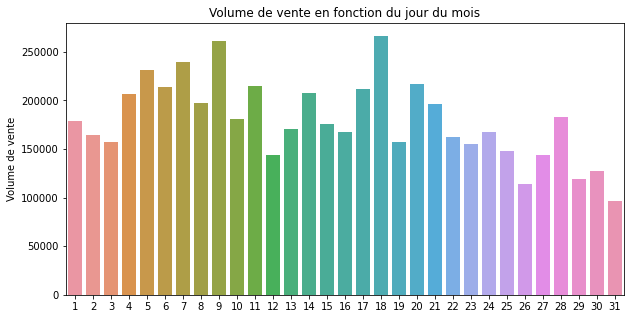

In [ ]:
#Représentation de la quantité en fonction du jour du mois
vis =df_sale[['Quantity','Day']].groupby('Day').sum().reset_index()
sns.barplot(x='Day',y='Quantity', data=vis).set(title='Volume de vente en fonction du jour du mois');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de vente')
fig =plt.gcf()
fig.set_size_inches(10,5)

# on remarque une saisonalité --> tendance à la baisse
# --> moins de ventes en début du mois et beaucoup moins de ventes à la fin du mois
#le volume de vente semble avoir un lien avec le jour du mois


In [ ]:
# Etude de la relation statistique entre Quantity et Day (test de l'anova)
result = statsmodels.formula.api.ols('Quantity ~ Day', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est > à 5% 
#On ne rejette pas l'hypothèse d'indépendance

# conclusion : Quantity ne dépend pas du jour d'achat du mois

,df,sum_sq,mean_sq,F,PR(>F)
Day,1.0,9.558963e+03,9558.962898,0.393652,0.530386
Residual,527791.0,1.281624e+10,24282.788859,NaN,NaN


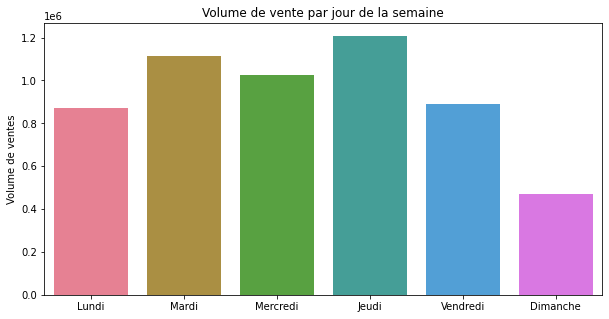

In [ ]:
#Représentation de la quantité en fonction du jour de la semaine
vis =df_sale[['Quantity','DayOfWeek']].groupby('DayOfWeek').sum().reset_index()
sns.barplot(x='DayOfWeek',y='Quantity',  palette='husl',data=vis).set(title='Volume de vente par jour de la semaine');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de ventes')
axes.xaxis.set_ticklabels(['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Dimanche']);
fig =plt.gcf()
fig.set_size_inches(10,5)

#On observe qu'il n'y a pas de ventes le Samedi
#Les jeudi et mardi sont les jours comptant le plus de vente.
#Le dimanche est le jour comptabilisant le moins de ventes.

#le volume de vente semble avoir un lien avec le jour de la semaine

In [ ]:
# Etude de la relation statistique entre Quantity et DayOfWeek (test de l'anova)
result = statsmodels.formula.api.ols('Quantity ~ DayOfWeek', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est < à 5% 
#On rejette l'hypothèse d'indépendance

# conclusion : Quantity dépend du jour d'achat de la semaine

,df,sum_sq,mean_sq,F,PR(>F)
DayOfWeek,1.0,9.899273e+04,98992.726303,4.076691,0.043479
Residual,527791.0,1.281615e+10,24282.619410,NaN,NaN


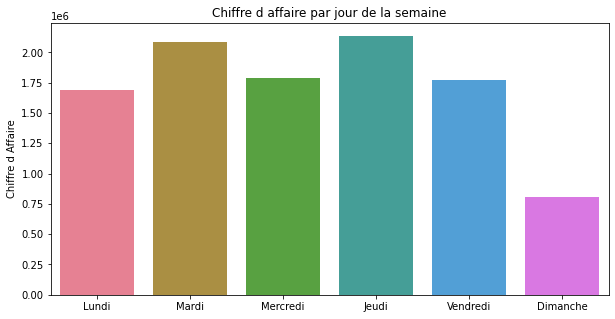

In [ ]:
# Représentation du chiffre d'affaire par jour de la semaine
vis =df_sale[['TotalAmount','DayOfWeek']].groupby('DayOfWeek').sum().reset_index()
sns.barplot(x='DayOfWeek',y='TotalAmount', palette='husl', data=vis).set(title='Chiffre d affaire par jour de la semaine');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Chiffre d Affaire')
axes.xaxis.set_ticklabels(['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Dimanche']);
fig =plt.gcf()
fig.set_size_inches(10,5)

# aucune données le samedi 
# chiffre d'affaire beaucoup plus faible le dimanche.
# et plus élevé le mardi et jeudi.
# Ce qui s'explique par la hausse des ventes le mardi et jeudi et la baisse le dimanche


In [ ]:
# Etude de la relation statistique entre Quantity et InvoiceDay (test de l'anova)
result = statsmodels.formula.api.ols('TotalAmount ~ DayOfWeek', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est > à 5% 
#On ne rejette pas l'hypothèse d'indépendance

# conclusion : TotalAmount ne dépend pas du jour d'achat de la semaine

,df,sum_sq,mean_sq,F,PR(>F)
DayOfWeek,1.0,4.752431e+05,475243.089666,3.303001,0.069154
Residual,540453.0,7.776157e+10,143882.210172,NaN,NaN


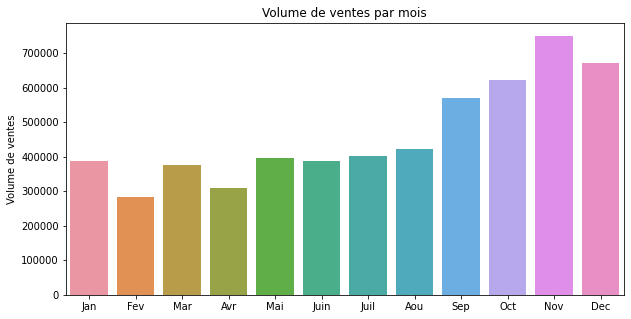

In [ ]:
# Représentation du volume de vente par mois
vis =df_sale[['Quantity','Month']].groupby('Month').sum().reset_index()
sns.barplot(x='Month',y='Quantity', data=vis).set(title='Volume de ventes par mois');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de ventes')
axes.xaxis.set_ticklabels(['Jan','Fev','Mar','Avr','Mai','Juin','Juil','Aou','Sep','Oct','Nov','Dec']);
fig =plt.gcf()
fig.set_size_inches(10,5)

# Hausse des ventes à partir de septembre. Les ventes atteignent un pic en novembre (période de fêtes)
#La quantité semble dépendre du mois de l'année
# ça n'a pas de sens de tester la dépendance statistique entre Quantity et Month car nous n'avons qu'une année d'historique 
# donc qu'une seule données par mois

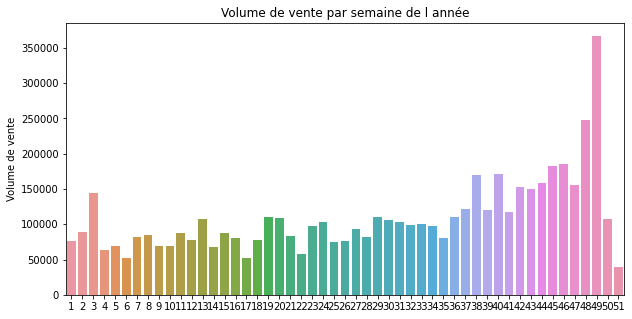

In [ ]:
#représentation du volume de ventes par semaine
volume_par_semaine = df_sale[['Quantity','Week']].groupby('Week').sum().reset_index()
sns.barplot(x='Week',y='Quantity', data=volume_par_semaine).set(title='Volume de vente par semaine de l année');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de vente')
fig =plt.gcf()
fig.set_size_inches(10,5)

# hausse des ventes à la fin de l'année (période des fêtes)
# Il semble y avoir un lien de dépendance entre la quantité et la semaine de l'année
# ça n'a pas de sens de tester la dépendance statistique entre Quantity et Week car nous n'avons qu'une année d'historique 
# donc qu'une seule données par semaine de l'année

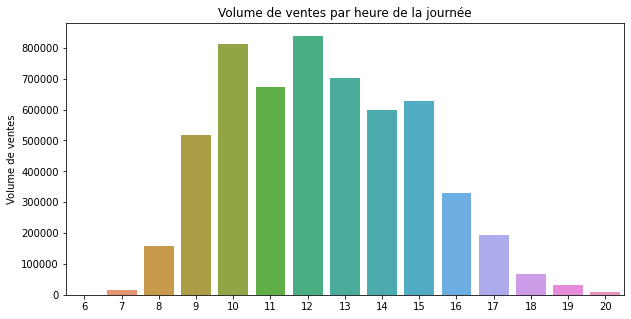

In [ ]:
#y a-t-il un lien de dépendance entre Quantity et Hour ? 
volume_par_heure = df_sale[['Quantity','Hour']].groupby('Hour').sum().reset_index()

sns.barplot(x='Hour',y='Quantity', data=volume_par_heure).set(title='Volume de ventes par heure de la journée');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de ventes')
fig =plt.gcf()
fig.set_size_inches(10,5)
# la quantité semble dépendre de l'heure de la transaction

In [ ]:
# les heures de ventes 
df_sale.Hour.unique()

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17,  7, 18, 19, 20,  6])

In [ ]:
''' les ventes ont lieu uniquement de 6h à 20h 
---> hypothèse : correspond à des horaires de bureau 
Il semble y avoir un lien entre quantity et Hour '''

In [ ]:
# Etude de la relation statistique entre Quantity et Hour (test de l'anova)
result = statsmodels.formula.api.ols('Quantity ~ Hour', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value < à 5% 
#On rejette l'hypothèse d'indépendance
# conclusion : Quantity dépend de l'heure de transaction

,df,sum_sq,mean_sq,F,PR(>F)
Hour,1.0,4.594808e+06,4.594808e+06,189.288496,4.624717e-43
Residual,527791.0,1.281165e+10,2.427410e+04,NaN,NaN


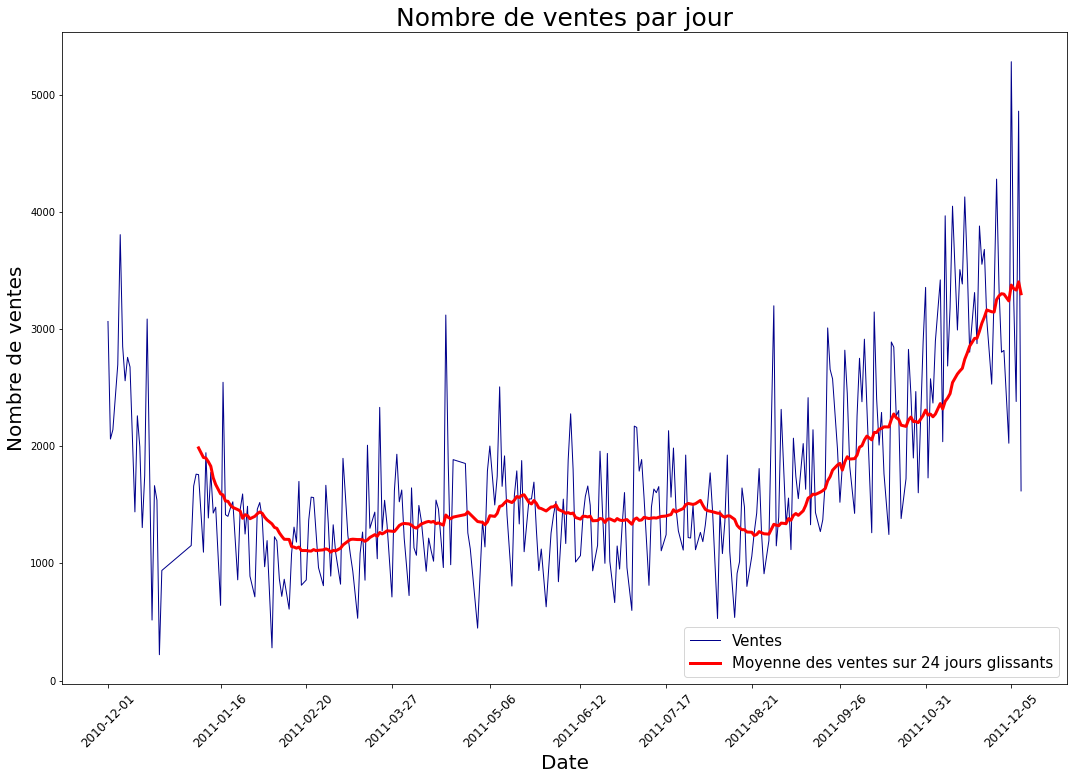

In [ ]:
#Historique de vente sur toute la période par jour
vis =df_sale[['InvoiceNo','Date']].groupby('Date').count().reset_index()
plt.plot(vis['Date'], vis['InvoiceNo'], label ='Ventes', linewidth = 1, color = 'darkblue')

#Moyenne sur 24 jours glissants (1 mois = +-24 jours ouvrables, ici ventes le dimanche mais pas le samedi donc on compte 6 jours par semaine)
plt.plot(vis['Date'], vis[['Date','InvoiceNo']].rolling(24).mean(),linewidth=3, color='red', label ='Moyenne des ventes sur 24 jours glissants')
plt.legend(loc='lower right', fontsize=15)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Nombre de ventes', fontsize=20)
plt.title('Nombre de ventes par jour', fontsize=25)
plt.xticks(vis['Date'][::30],fontsize=12, rotation = 45)
fig =plt.gcf()
fig.set_size_inches(18,12)

#La moyenne de vente augmente avec les années (décembre 2010 est moins performant que décembre 2011), hypothèse d'une entreprise en progression
#On observe de nouveau au pic sur le dernier trimestre de l'année
#La moyenne des ventes des 3 premiers trimestres ne semble pas montrer de fortes évolutions

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



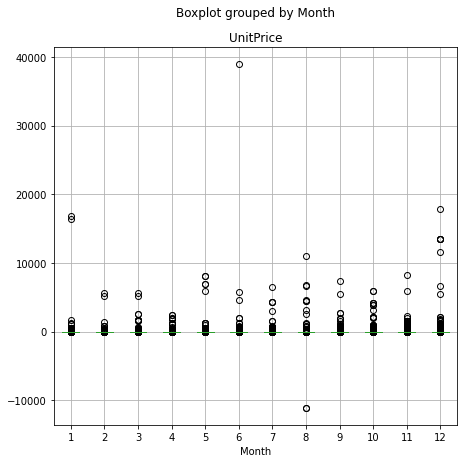

In [ ]:
## Prix unitaire des produits commandés par mois
# boxplot qui affiche UnitPrice groupé par InvoiceMonth

df.boxplot(column='UnitPrice', by='Month', figsize=(7, 7));

# L'objectif est d'analyser visuellement si il existe une saisonnalité des prix des produits commandés. 
#(par exemple, si en été, les clients commandent des produits plus cher qu'en hiver, etc..
# Ainsi, nous pouvons observer une forme de régularité dans les prix des produits commandés tout au long de l'année

In [ ]:
# Etude de la relation statistique entre UnitPrice et Month (test de l'anova)
result = statsmodels.formula.api.ols('UnitPrice ~ Month', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est < à 5% 
#On rejette l'hypothèse d'indépendance

# conclusion : UnitPrice dépend du mois d'achat
# cela est peut-être dû aux valeurs très éloignées pour le 6ème mois et le 8ème mois 

,df,sum_sq,mean_sq,F,PR(>F)
Month,1.0,1.938158e+03,1938.157621,101.009588,9.199145e-24
Residual,527791.0,1.012718e+07,19.187858,NaN,NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



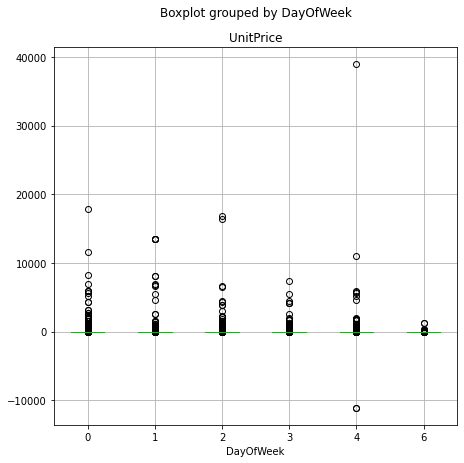

In [ ]:
## Prix unitaire des produits commandé selon le jour de la semaine
# boxplot qui affiche UnitPrice groupé par InvoiceDay

df.boxplot(column='UnitPrice', by='DayOfWeek', figsize=(7, 7));

# On peut observer qu'en semaine, et particulièrement le lundi, les clients commandent 
# des produits avec un prix unitaire élevé, relativement aux autres 
# jours de la semaine et particulièrement le dimanche
# il semblerait y avoir un lien entre le prix et le jour d'achat

In [ ]:
# Etude de la relation statistique entre UnitPrice et DayOfWeek (test de l'anova)
result = statsmodels.formula.api.ols('UnitPrice ~ DayOfWeek', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est < à 5% 
#On rejette l'hypothèse d'indépendance

# conclusion : UnitPrice dépend du jour de la semaine

,df,sum_sq,mean_sq,F,PR(>F)
DayOfWeek,1.0,1.092508e+04,10925.084441,569.880603,6.954776e-126
Residual,527791.0,1.011819e+07,19.170830,NaN,NaN


## *Visualisations sur les produits phares*

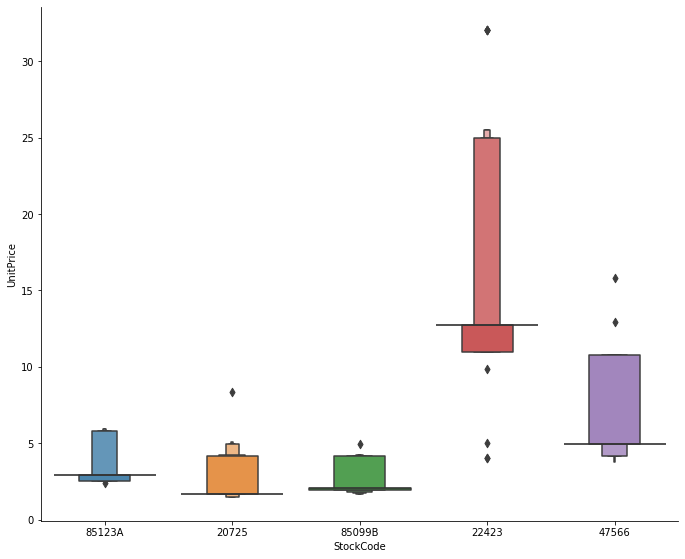

In [ ]:
#TOP 5 des produits les plus vendus (souhaité le pareto pour les 20/80 mais pb de RAM)
codes=["85123A","85099B","22423","47566","20725"]
new =df_sale["StockCode"].isin(codes)
df_sale[new]
sns.catplot(data=df_sale[new], x='StockCode',y='UnitPrice', kind='boxen')
fig =plt.gcf()
fig.set_size_inches(10,8)
#Sur le top produit, les 3 premiers sont vendues en moyenne +-2.5€
#Le 3ème produit est le plus cher du top (+-13€)
#Le 4ème produit à +-6€

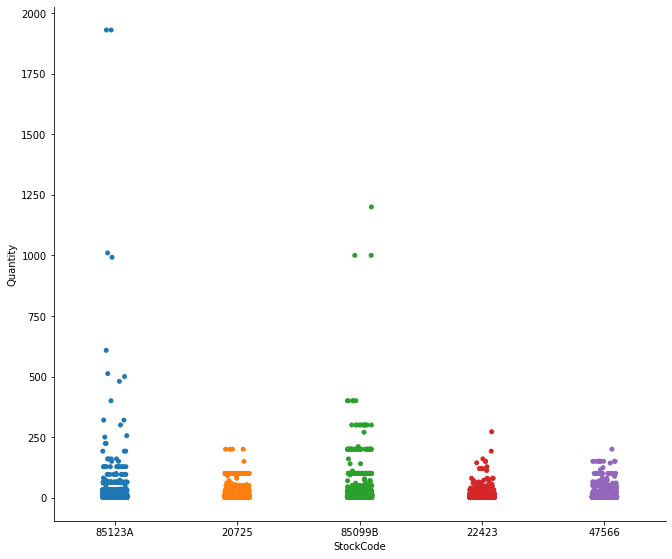

In [ ]:
#Quantité des produits achetés par commandes
sns.catplot(x='StockCode', y='Quantity', data =df_sale[new]);
fig =plt.gcf()
fig.set_size_inches(10,8)
#1er et 3eme produits correspondont à quelques grosse commandes (presque 2000pièces par commandes, ou 1000)
#Pour la majorité des commandes sur ce top produits, les produits sont achetés entre 1 et 200pièces par factures

## *Analyse par pays*

Volume de ventes par pays

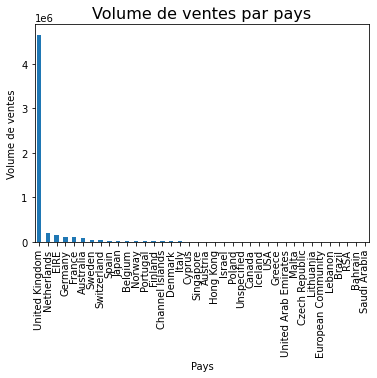

In [ ]:
#Volume de ventes par pays
orders_by_country = df_sale.groupby('Country')['Quantity'].sum().sort_values(ascending=False)

#Plot
orders_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Volume de ventes')
plt.title('Volume de ventes par pays', fontsize=16)
plt.show()

#incontestablement, le pays qui concentre le plus d'activité commerciale 
# est le United Kingdom

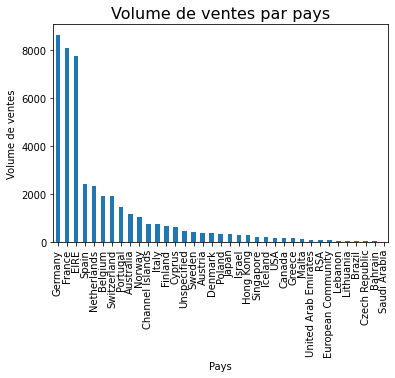

In [ ]:
#Nombre de commandes par Pays - hors United Kingdom
quantity_by_country = df_sale.groupby('Country')['Quantity'].count().sort_values(ascending=False)
del quantity_by_country['United Kingdom']
#Plot
quantity_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Volume de ventes')
plt.title('Volume de ventes par pays', fontsize=16)
plt.show()

# Le pays United Kingdom, est suivi par l'Allemagne, la France

#la quantity semble dépendre du pays d'où provient la commande

In [ ]:
#Analyse de la relation  Quantity & Country
#Pour étudier les relations entre variables quantitatives et qualitatives, on utilise l'analyse de la variance ANOVA

import statsmodels.api 
result = statsmodels.formula.api.ols('Quantity ~ Country', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#Si la p-value (PR(>F)) est inférieur à 5% 
#Alors on rejette l'hypothèse selon laquelle Country n'influe pas sur Quantity.

# conclusion : Quantity dépend de Country

,df,sum_sq,mean_sq,F,PR(>F)
Country,37.0,2.296419e+07,620653.869812,25.603529,1.324953e-174
Residual,527755.0,1.279328e+10,24240.950404,NaN,NaN


Nombre de commandes par pays

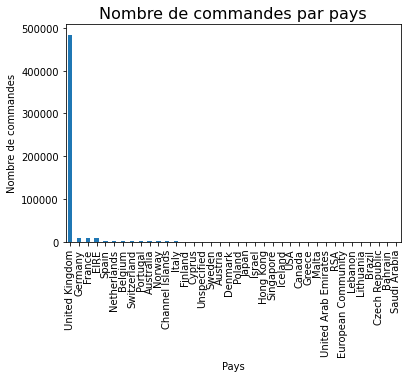

In [ ]:
#nombre de commandes par pays
orders_by_country = df_sale.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)

#Plot
orders_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Nombre de commandes')
plt.title('Nombre de commandes par pays', fontsize=16)
plt.show()

#incontestablement, le pays qui concentre le plus d'activité commerciale 
# est le United Kingdom

Nombre de commandes par Pays - hors UK

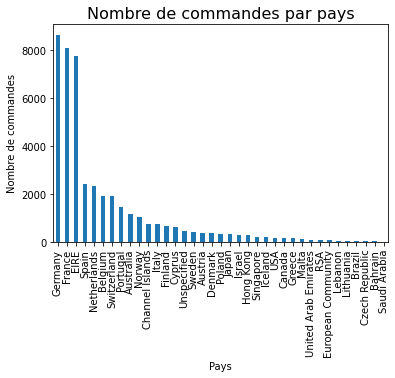

In [ ]:
#Nombre de commandes par Pays - hors United Kingdom
orders_by_country = df_sale.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
del orders_by_country['United Kingdom']
#Plot
orders_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Nombre de commandes')
plt.title('Nombre de commandes par pays', fontsize=16)
plt.show()

# Le pays United Kingdom, est suivi par l'Allemagne, la France


Montant moyen dépensé par pays

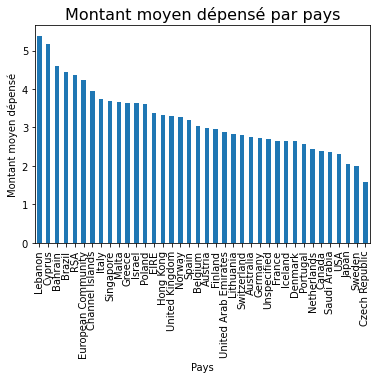

In [ ]:
#Montant moyen dépensé par pays
spend_by_country = df_sale.groupby('Country')['UnitPrice'].mean().sort_values(ascending=False)
#Plot
spend_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Montant moyen dépensé')
plt.title('Montant moyen dépensé par pays', fontsize=16)
plt.show()

# A Chypre et au Liban, les clients passent les commandes les plus importantes en 
# terme de tarif dépensé, suivi du Bahrein 



In [ ]:
#relation entre les variables country et unitprice
result = statsmodels.formula.api.ols('UnitPrice ~ Country', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table
#p-value < 5%, on rejette l'hypothèse d'indépendance entre country et unitprice
# conclusion : country dépend de unitprice

,df,sum_sq,mean_sq,F,PR(>F)
Country,37.0,1.448828e+04,391.575080,20.431369,7.991479e-135
Residual,527755.0,1.011463e+07,19.165387,NaN,NaN
